In [1]:
from os.path import expanduser
import json
from statistics import mean, stdev
import datetime as dt
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from functions.data import stationary_neighborhoods, non_stationary_neighborhoods
from functions.plotting import plot_empty

with open(expanduser('.db/postgres.json')) as f:
    cred = json.load(f)
    username = cred.get("user")
    password = cred.get("password")
    host = cred.get("host")
    port = cred.get("port")
    
# sqlalchemy connection arguments
db_name = "sf_rent_petitions"
connection_str = f'postgres://{username}:{password}@{host}:{port}/{db_name}' # sqlalchemy connection args

In [2]:
save=False

# Get Data

In [3]:
# Check
query = """
SELECT date, neighborhood_number, neighborhood_name, num_petition_id
FROM petitions
;
"""
petition_df = pd_sql.read_sql(query, connection_str, parse_dates=['date']) # grab data as a dataframe
petition_df = petition_df.reset_index(drop=True)
petition_df.head()

,date,neighborhood_number,neighborhood_name,num_petition_id
0,2019-03-29,2.0,Bernal Heights,1
1,2019-03-29,9.0,Hayes Valley,2
2,2019-03-29,32.0,Russian Hill,1
3,2019-03-29,35.0,Sunset/Parkside,1
4,2019-03-29,9.0,Hayes Valley,1


In [4]:
# Get counts
neighborhood_counts_df = petition_df.groupby([pd.Grouper(key="date", freq="M"), "neighborhood_name"])[
    ["neighborhood_name"]
].size().unstack().fillna(0)

# Seasonal Decompose

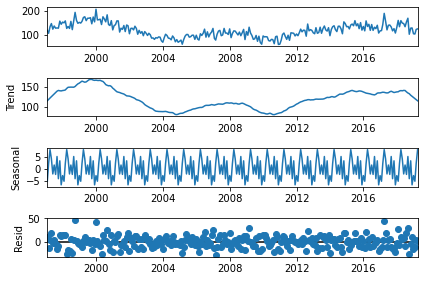

In [5]:
# Decompose
petition_decomp = seasonal_decompose(neighborhood_counts_df[non_stationary_neighborhoods].sum(axis=1), model='additive', extrapolate_trend = True)

# Move data into dataframe
petition_decomp_df = pd.DataFrame([petition_decomp.observed,
              petition_decomp.trend,
              petition_decomp.seasonal,
              petition_decomp.resid
             ]).T.rename(columns={'Unnamed 0': 'observed'})
petition_decomp_df['sum'] = petition_decomp_df.sum(axis=1)-petition_decomp_df['observed']
petition_decomp_df.columns = [col.capitalize() for col in petition_decomp_df.columns]
petition_decomp_df = petition_decomp_df.reset_index()

# derive additional features
seasonal_min = min(petition_decomp_df['Seasonal'])
petition_decomp_df['Adj. Trend'] = petition_decomp_df['Trend'] + seasonal_min
petition_decomp_df['Adj. Seasonal'] = petition_decomp_df['Seasonal'] - seasonal_min
petition_decomp_df['Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid']
petition_decomp_df['Adj. Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid'] + seasonal_min

# small plot
petition_decomp.plot();

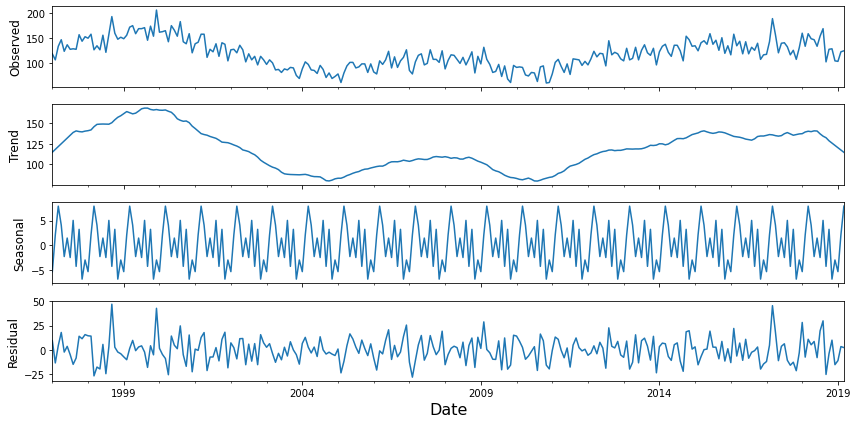

In [6]:
# Large Plot

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,6))
petition_decomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed', fontsize = 12)
petition_decomp.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend', fontsize = 12)
petition_decomp.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal', fontsize = 12)
petition_decomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual', fontsize = 12)
axes[3].set_xlabel('Date', fontsize = 16)
plt.tight_layout()
if save:
    plt.savefig('figures/sarima/seasonal-decomp.png', transparent = True, bbox_inches = 'tight')
plt.show()

# Train-Test Split

In [7]:
# Split data
split_date = dt.datetime(2014, 1, 31)

petition_train_df = petition_decomp_df[
    (petition_decomp_df['date'] <= split_date)][['date', 'Observed', 'Adj. Trend', 'Adj. Signal', 'Adj. Seasonal', 'Resid']]
petition_test_df = petition_decomp_df[
    (petition_decomp_df['date'] > split_date)][['date', 'Observed', 'Adj. Trend', 'Adj. Signal', 'Adj. Seasonal', 'Resid']]

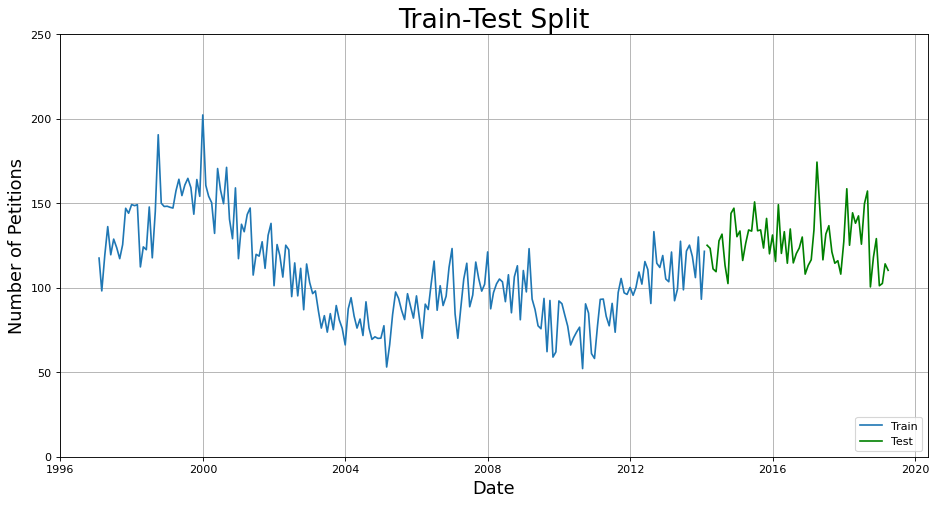

In [8]:
# Plot

fig, ax = plot_empty(xlabel='Date', ylabel='Number of Petitions', title='Train-Test Split',
                     figsize=(14, 7))
plt.plot(petition_train_df[['date', 'Adj. Signal']].set_index('date'), label = 'Train')
plt.plot(petition_test_df[['date', 'Adj. Signal']].set_index('date'), label = 'Test', color = 'g')
plt.ylim(0, 250)
plt.legend(loc = 'lower right')
ax.grid(True)
if save:
    plt.savefig("figures/sarima/train-test-split.png", transparent=True, bbox_inches="tight")

# Forecast on Adj. Signal

Adjusted Signal is defined as Trend + Resid + const.

/home/harrisonized/anaconda3/envs/basic/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


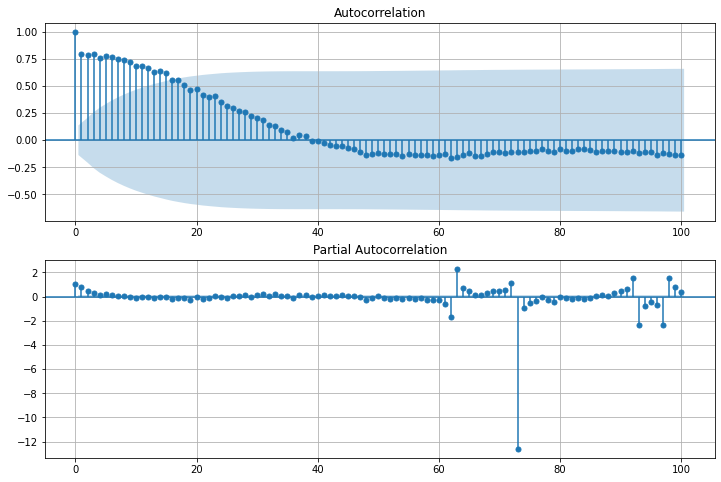

In [9]:
# Plot autocorrelation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(petition_train_df[['date', 'Adj. Signal']].set_index('date'), lags=100, ax=ax1)
ax1.grid(True)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(petition_train_df[['date', 'Adj. Signal']].set_index('date'), lags=100, ax=ax2)
ax2.grid(True)

if save:
    plt.savefig("figures/sarima/acf-pacf-baseline.png", transparent = True, bbox_inches = 'tight')
plt.show()

In [10]:
mod = sm.tsa.statespace.SARIMAX(petition_train_df[['date', 'Adj. Signal']].set_index('date'),
                                order=(1, 0, 1),
                                seasonal_order=(2, 1, 0, 15),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'M')

results = mod.fit()

# Results
train = results.get_prediction(start=pd.to_datetime('1997-1-31'), end = pd.to_datetime('2014-1-31'), dynamic=False)
train_ci = train.conf_int()
test = results.get_prediction(start=pd.to_datetime('2014-2-28'), end = pd.to_datetime('2019-03-31'), dynamic=False)
test_ci = test.conf_int()

/home/harrisonized/anaconda3/envs/basic/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


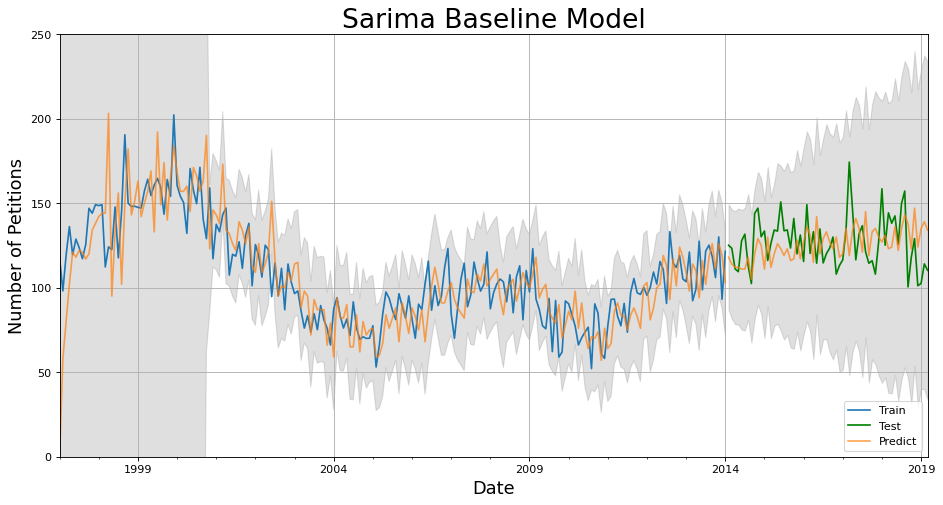

In [11]:
# Plot
fig, ax = plot_empty(ylabel='Number of Petitions', title='Sarima Baseline Model',
                     figsize=(14, 7))
petition_train_df[['date', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Train'}).set_index('date').plot(ax=ax)
petition_test_df[['date', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Test'}).set_index('date').plot(ax=ax, color = 'g')

# Predict
train.predicted_mean.round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index, train_ci.iloc[:, 0], train_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval
test.predicted_mean.round().plot(ax=ax, label = '_nolegend_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index, test_ci.iloc[:, 0], test_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval

ax.set_xlabel('Date')
ax.set_ylim(0, 250)
ax.legend(loc='lower right')
ax.grid(True)
if save:
    plt.savefig('figures/sarima/sarima-baseline.png', transparent = True, bbox_inches="tight")

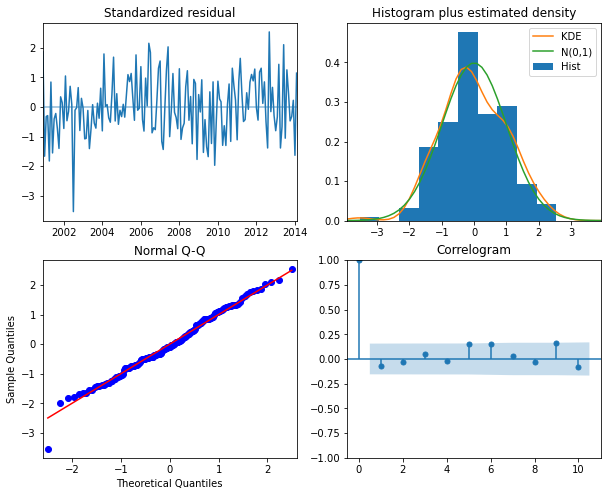

In [12]:
# Diagnostic Plots
results.plot_diagnostics(figsize=(10, 8));

In [13]:
# MAE for 3 months
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['date', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index('date')['Observed'])[0:4]
    ))

4.947257905138315

In [14]:
# MAE for 1 year
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['date', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index('date')['Observed'])[0:13]
    ))

11.389796797405486

In [15]:
# MAE for 5 years
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['date', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index('date')['Observed'])
    ))

14.808793138254922

# Forecast on Trend

/home/harrisonized/anaconda3/envs/basic/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


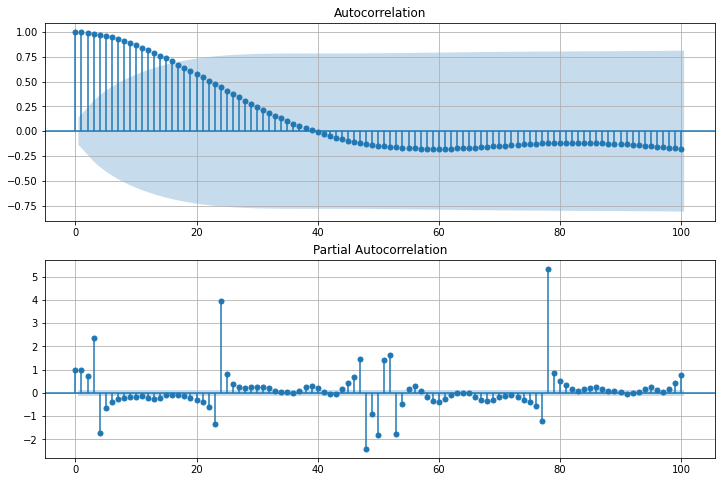

In [16]:
# Plot autocorrelation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(petition_train_df[['date', 'Adj. Trend']].set_index('date'), lags=100, ax=ax1)
ax1.grid(True)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(petition_train_df[['date', 'Adj. Trend']].set_index('date'), lags=100, ax=ax2)
ax2.grid(True)

if save:
    plt.savefig("figures/sarima/acf-pacf-trend.png", transparent = True, bbox_inches = 'tight')
plt.show()

In [17]:
mod = sm.tsa.statespace.SARIMAX(petition_train_df[['date', 'Adj. Trend']].set_index('date'),
                                order=(4, 0, 1),
                                seasonal_order=(1, 1, 1, 16),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                               freq = 'M')

results = mod.fit()

# Results
train = results.get_prediction(start=pd.to_datetime('1997-1-31'), end = pd.to_datetime('2014-1-31'), dynamic=False)
train_ci = train.conf_int()
test = results.get_prediction(start=pd.to_datetime('2014-2-28'), end = pd.to_datetime('2019-03-31'), dynamic=False)
test_ci = test.conf_int()

/home/harrisonized/anaconda3/envs/basic/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/harrisonized/anaconda3/envs/basic/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


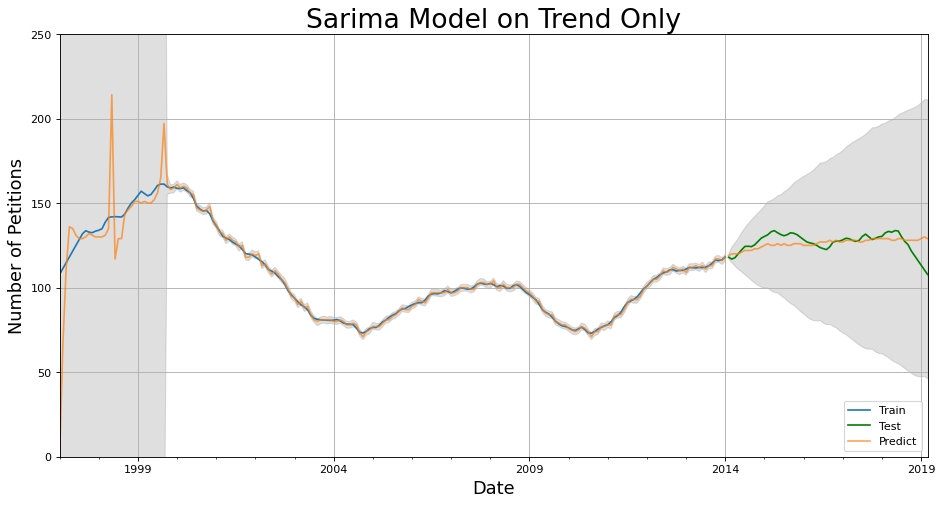

In [18]:
# Plot
fig, ax = plot_empty(ylabel='Number of Petitions', title='Sarima Model on Trend Only',
                     figsize=(14, 7))
petition_train_df[['date', 'Adj. Trend']].rename(columns = {'Adj. Trend': 'Train'}).set_index('date').plot(ax=ax)
petition_test_df[['date', 'Adj. Trend']].rename(columns = {'Adj. Trend': 'Test'}).set_index('date').plot(ax=ax, color = 'g')

# Predict
train.predicted_mean.round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index, train_ci.iloc[:, 0], train_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval
test.predicted_mean.round().plot(ax=ax, label = '_nolegend_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index, test_ci.iloc[:, 0], test_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval

ax.set_xlabel('Date')
ax.set_ylim(0, 250)
ax.legend(loc='lower right')
ax.grid(True)
if save:
    plt.savefig('figures/sarima/sarima-trend-only.png', transparent = True, bbox_inches="tight")

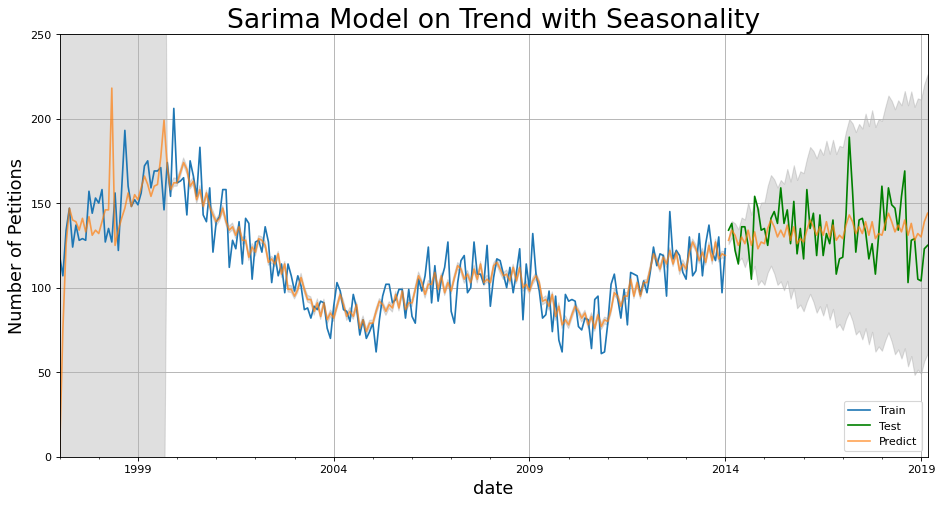

In [19]:
# Plot
fig, ax = plot_empty(ylabel='Number of Petitions', title='Sarima Model on Trend with Seasonality',
                     figsize=(14, 7))
petition_train_df[['date', 'Observed']].rename(columns = {'Observed': 'Train'}).set_index('date').plot(ax=ax)
petition_test_df[['date', 'Observed']].rename(columns = {'Observed': 'Test'}).set_index('date').plot(ax=ax, color = 'g')

# Results
(train.predicted_mean + petition_train_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']).round() \
    .round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index,
                train_ci.iloc[:, 0] + petition_train_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal'],
                train_ci.iloc[:, 1] + petition_train_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal'],
                color='grey', alpha=.25)
(test.predicted_mean + petition_test_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']).round() \
    .plot(ax=ax, label='_nolabel_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index,
                (test_ci.iloc[:, 0] + petition_test_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']),
                (test_ci.iloc[:, 1] + petition_test_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']),
                color='grey', alpha=.25)

ax.legend(loc='lower right')
ax.set_ylim(0, 250)
ax.grid(True)

if save:
    plt.savefig('figures/sarima/sarima-trend-with-seasonality', transparent = True, bbox_inches="tight")

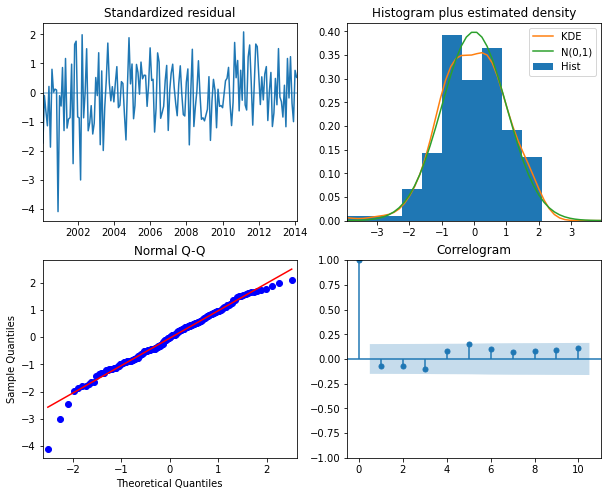

In [20]:
# Diagnostic Plots
results.plot_diagnostics(figsize=(10, 8));

In [21]:
# MAE for 3 months
mean(abs(
    ((test.predicted_mean \
      + petition_test_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']).round() \
      - petition_test_df[['date', 'Observed']].rename(columns = {'Observed': 'Out Of Sample'}) \
      .set_index('date')['Out Of Sample'])[0:4]
    ))

7.5

In [22]:
# MAE for 1 year
mean(abs(
    ((test.predicted_mean \
      + petition_test_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']).round() \
      - petition_test_df[['date', 'Observed']].rename(columns = {'Observed': 'Out Of Sample'}) \
      .set_index('date')['Out Of Sample'])[0:13]
    ))

11.23076923076923

In [23]:
# MAE for 5 years
mean(abs(
    ((test.predicted_mean \
      + petition_test_df[['date', 'Adj. Seasonal']].set_index('date')['Adj. Seasonal']).round() \
      - petition_test_df[['date', 'Observed']].rename(columns = {'Observed': 'Out Of Sample'}) \
      .set_index('date')['Out Of Sample'])
    ))

12.46774193548387